In [1]:
import os, pickle, cloudpickle
import pandas as pd
import numpy as np
import shapely, shapely.wkt
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import os.path as path


Bad key "text.kerning_factor" on line 4 in
/Users/yhannnn/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# specify number of stations want to increase
NUM_STATIONS_INC = 1

In [3]:
# specify dir
CITY = "P_"
save_dir = CITY + 'clas_res/'
save_dir_preprocess = os.path.join(save_dir, CITY + 'preprocess_fig/')
save_dir_models = os.path.join(save_dir, CITY + 'model_res/') 
save_dir_forecast = os.path.join(save_dir, CITY + 'forecast/')
save_dir_fairst = os.path.join(save_dir, CITY + 'fairst/')

In [27]:
# load unmitigated random forest
with open(os.path.join(save_dir_models, CITY + "random_forest.pkl"), 'rb') as file:  
    rf_best = pickle.load(file)

# load exponentiated gradient
with open(os.path.join(save_dir_models, CITY + "exp_grad_SP.pkl"), 'rb') as file:  
    eg_best = cloudpickle.load(file)

# load grid search
with open(os.path.join(save_dir_models, CITY + "grid_search_SP.pkl"), 'rb') as file:  
    gs_best = pickle.load(file)

In [28]:
# load necessary datasets
df_pgh_census = pd.read_csv(os.path.join(save_dir_forecast, CITY + "df_pgh_census.csv"), index_col = 0)
df_weather = pd.read_csv(os.path.join(save_dir_forecast, CITY + "df_weather_final.csv"), index_col = 0)
X_train = pd.read_csv(os.path.join(save_dir_forecast, CITY + "X_train.csv"), index_col = 0)
df_geo = pd.read_csv(os.path.join(save_dir_forecast, CITY + "geo_df.csv"), index_col = 0)
for row,col in df_geo.iterrows():
    df_geo.at[row, 'geometry'] = shapely.wkt.loads(df_geo.loc[row]['geometry'])
df_station_cap = pd.read_csv(os.path.join(save_dir_forecast, CITY + "df_station_cap.csv"), index_col = 0)

In [29]:
df_walk_score = pd.read_csv("data/walkscoresAPI.csv", index_col = 0)
df_walk_score

,cell_num,walk_score,bike_score,transit_score,nearby
0,51,9,15,-1,NaN
1,52,3,8,22,"2 nearby routes: 2 bus, 0 rail, 0 other"
2,82,14,25,29,"3 nearby routes: 3 bus, 0 rail, 0 other"
3,83,12,40,27,"3 nearby routes: 3 bus, 0 rail, 0 other"
4,84,2,7,24,"2 nearby routes: 2 bus, 0 rail, 0 other"
...,...,...,...,...,...
723,1587,21,19,47,"22 nearby routes: 22 bus, 0 rail, 0 other"
724,1588,19,19,41,"14 nearby routes: 14 bus, 0 rail, 0 other"
725,1589,48,37,-1,NaN
726,1619,21,24,41,"16 nearby routes: 16 bus, 0 rail, 0 other"


In [30]:
# load two datasets
# extract parts from "nearby"

df_walk_score['nearby_bus'] = 0
df_walk_score['nearby_rail'] = 0
df_walk_score['nearby_other'] = 0
df_walk_score['nearby_routes'] = 0

for row,col in df_walk_score.iterrows():
    # if nearby == NaN
    if type(df_walk_score.loc[row]['nearby']) == float:
        df_walk_score.at[row, 'nearby_bus'] = 0
        df_walk_score.at[row, 'nearby_rail'] = 0
        df_walk_score.at[row, 'nearby_other'] = 0
        
    else:
        routes = df_walk_score.loc[row]['nearby']
        routes = routes.split(' ')
        nearby_routes = routes[0]
        nearby_bus = routes[3]
        nearby_rail = routes[5]
        nearby_other = routes[7]

        df_walk_score.at[row, 'nearby_bus'] = nearby_bus
        df_walk_score.at[row, 'nearby_rail'] = nearby_rail
        df_walk_score.at[row, 'nearby_other'] = nearby_other
        df_walk_score.at[row, 'nearby_routes'] = nearby_routes
        
df_walk_score.drop(columns = ["nearby"], inplace = True)
df_walk_score.reset_index(drop = True, inplace = True)

# censusTract

df_walk_score_temp = df_walk_score.groupby("cell_num").mean().reset_index()

for col in df_walk_score_temp.columns:
    df_walk_score_temp[col] = df_walk_score_temp[col].astype(int)
    
df_walk_score_temp.head()

,cell_num,walk_score,bike_score,transit_score,nearby_bus,nearby_rail,nearby_other,nearby_routes
0,51,9,15,-1,0,0,0,0
1,52,3,8,22,2,0,0,2
2,82,14,25,29,3,0,0,3
3,83,12,40,27,3,0,0,3
4,84,2,7,24,2,0,0,2


In [31]:
df_merge = df_pgh_census.merge(df_walk_score_temp, on = 'cell_num', how = "left")
df_merge

,cell_num,median_hh_income,population_16yrs+,total_households,mean_travel_time_to_work,Workers_16yrs+,perc_public,perc_walk,perc_other,perc_employed,...,wfh,own_alone,carpool,walk_score,bike_score,transit_score,nearby_bus,nearby_rail,nearby_other,nearby_routes
0,51,67409,2660,1306,23,1695,0.156342,0.037168,0.0,0.634586,...,58,1083,226,9,15,-1,0,0,0,0
1,52,67409,2660,1306,23,1695,0.156342,0.037168,0.0,0.634586,...,58,1083,226,3,8,22,2,0,0,2
2,82,67409,2660,1306,23,1695,0.156342,0.037168,0.0,0.634586,...,58,1083,226,14,25,29,3,0,0,3
3,83,67409,2660,1306,23,1695,0.156342,0.037168,0.0,0.634586,...,58,1083,226,12,40,27,3,0,0,3
4,84,67409,2660,1306,23,1695,0.156342,0.037168,0.0,0.634586,...,58,1083,226,2,7,24,2,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,1587,30089,2394,1391,26,1066,0.181051,0.000000,0.0,0.462824,...,179,581,113,21,19,47,22,0,0,22
724,1588,30089,2394,1391,26,1066,0.181051,0.000000,0.0,0.462824,...,179,581,113,19,19,41,14,0,0,14
725,1589,30089,2394,1391,26,1066,0.181051,0.000000,0.0,0.462824,...,179,581,113,48,37,-1,0,0,0,0
726,1619,30089,2394,1391,26,1066,0.181051,0.000000,0.0,0.462824,...,179,581,113,21,24,41,16,0,0,16


In [32]:
df_all = df_merge.merge(df_station_cap, how = 'left', on = "cell_num").fillna(0)
df_all.stations = df_all.stations.astype(int)
df_all.capacity = df_all.capacity.astype(int)

In [33]:
# duplicate rows 
df_forc = pd.DataFrame(np.repeat(df_all.values, 12, axis=0))
df_forc.columns = df_all.columns

# load 2019 weather
df_weather_19 = df_weather[df_weather.year == 2019]

# attach weather & month
for index, col in df_forc.iterrows():
    curr_month = index%12 + 1
    
    df_forc.at[index, "month"] = curr_month
    df_forc.at[index, "temp"] = df_weather_19[df_weather_19.month == curr_month].temp.values[0]

df_forc.month = df_forc.month.astype(int)

# save cell_num
cell_num = df_forc["cell_num"]
df_forc.drop(columns = "cell_num", inplace = True)

In [34]:
# training set
df_forc["median_hh_income"] = df_forc["median_hh_income"].replace("-", 0)
df_forc.median_hh_income = df_forc.median_hh_income.astype(int)

int_col = ["population_16yrs+", "total_households", "mean_travel_time_to_work", "Workers_16yrs+", "wfh", 
          'own_alone', 'carpool', 'walk_score', 'bike_score', 'transit_score', 'nearby_bus', 
           'nearby_rail', 'nearby_other', 'nearby_routes', 'stations', 'capacity', 'month']
float_col = ['perc_public', 'perc_walk', 'perc_other', 'perc_employed', 'perc_unemployed', 'temp']

for col in int_col:
    df_forc[col] = df_forc[col].astype(int)

for col in float_col:
    df_forc[col] = df_forc[col].astype(float)


In [35]:
df_forc["income_group"] = 0

for row, col in df_forc.iterrows():
    
    if df_forc.loc[row]["median_hh_income"] > 50000:
        df_forc.at[row, "income_group"] = 1
        
df_forc.drop(columns = ["median_hh_income"], inplace = True)

# sns.countplot(">50K", data = df_forc)
# plt.title("Distribution of income")

In [36]:
df_forc = df_forc[X_train.columns]

In [37]:
df_forc_new = df_forc.copy()
df_forc_new["stations"] += NUM_STATIONS_INC

In [38]:
## new prediction
new_pred_random_forest = rf_best.predict(df_forc_new)
new_pred_exp_grad = eg_best.predict(df_forc_new, random_state = 42)
new_pred_grid_search = gs_best.predict(df_forc_new)

In [39]:
pred_df = cell_num.to_frame()
pred_df["month"] = df_forc_new["month"]
pred_df["income_group"] = df_forc_new["income_group"]
# pred_df["stations_added"] = df_forc_new["stations"]

In [40]:
pred_df["stations_added"] = df_forc_new["stations"]
# pred_df[pred_df.stations_added > 0]

In [41]:
cell_num2stations_df = pred_df.groupby("cell_num").mean().reset_index()[["cell_num", "stations_added"]]
# cell_num2stations_df.stations_added = cell_num2stations_df.stations_added.astype(int)
cell_num2stations_df

,cell_num,stations_added
0,51,1.0
1,52,1.0
2,82,1.0
3,83,1.0
4,84,1.0
...,...,...
723,1587,1.0
724,1588,1.0
725,1589,1.0
726,1619,1.0


In [42]:
pred_df["new_pred_random_forest"] = new_pred_random_forest
pred_df["new_pred_exp_grad"] = new_pred_exp_grad
pred_df["new_pred_grid_search"] = new_pred_grid_search

In [43]:
# sum over months
# attach # of stations info
pred_df_yearly = pred_df.groupby("cell_num").sum().reset_index().drop(columns = ["month"])
pred_df_yearly["income_group"] = pred_df_yearly["income_group"].apply(lambda x: "high_income" if x > 0 else "low_income")
pred_df_yearly = pred_df_yearly.merge(cell_num2stations_df, on = "cell_num", how = 'left')
pred_df_yearly = pred_df_yearly.merge(df_geo, on = "cell_num")
pred_df_yearly = gpd.GeoDataFrame(pred_df_yearly, crs='EPSG:2956', geometry='geometry')
pred_df_yearly

,cell_num,income_group,stations_added_x,new_pred_random_forest,new_pred_exp_grad,new_pred_grid_search,stations_added_y,geometry,centroid
0,51,high_income,12,0,1,2,1.0,"POLYGON ((-80.09534 40.44884, -80.09534 40.453...",POINT (-80.09304131033451 40.45113079550194)
1,52,high_income,12,0,2,2,1.0,"POLYGON ((-80.09534 40.45343, -80.09534 40.458...",POINT (-80.09304131033451 40.45572158403908)
2,82,high_income,12,0,2,2,1.0,"POLYGON ((-80.09075 40.44424, -80.09075 40.448...",POINT (-80.08845052179737 40.44654000696479)
3,83,high_income,12,0,1,2,1.0,"POLYGON ((-80.09075 40.44884, -80.09075 40.453...",POINT (-80.08845052179737 40.45113079550194)
4,84,high_income,12,0,1,2,1.0,"POLYGON ((-80.09075 40.45343, -80.09075 40.458...",POINT (-80.08845052179737 40.45572158403908)
...,...,...,...,...,...,...,...,...,...
723,1587,low_income,12,1,2,2,1.0,"POLYGON ((-79.87498 40.44884, -79.87498 40.453...",POINT (-79.87268346055095 40.45113079550194)
724,1588,low_income,12,1,3,2,1.0,"POLYGON ((-79.87498 40.45343, -79.87498 40.458...",POINT (-79.87268346055095 40.45572158403908)
725,1589,low_income,12,1,0,2,1.0,"POLYGON ((-79.87498 40.45802, -79.87498 40.462...",POINT (-79.87268346055095 40.46031237257623)
726,1619,low_income,12,1,3,2,1.0,"POLYGON ((-79.87039 40.44884, -79.87039 40.453...",POINT (-79.8680926720138 40.45113079550194)


### visualize

In [44]:
### save income group copy
df_income = df_pgh_census[["cell_num", "median_hh_income"]]
df_income["median_hh_income"] = df_income["median_hh_income"].replace("-", 0)
df_income.median_hh_income = df_income.median_hh_income.astype(int)
df_income["income_group"] = df_income["median_hh_income"].apply(lambda x: 1 if x>50000 else 0)
df_income = df_income.merge(df_geo, on = "cell_num")[["cell_num", "income_group", "geometry", "centroid"]]

df_income = gpd.GeoDataFrame(df_income, crs='EPSG:2956', geometry='geometry')
df_income

/Users/yhannnn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/yhannnn/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/yhannnn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

,cell_num,income_group,geometry,centroid
0,51,1,"POLYGON ((-80.09534 40.44884, -80.09534 40.453...",POINT (-80.09304131033451 40.45113079550194)
1,52,1,"POLYGON ((-80.09534 40.45343, -80.09534 40.458...",POINT (-80.09304131033451 40.45572158403908)
2,82,1,"POLYGON ((-80.09075 40.44424, -80.09075 40.448...",POINT (-80.08845052179737 40.44654000696479)
3,83,1,"POLYGON ((-80.09075 40.44884, -80.09075 40.453...",POINT (-80.08845052179737 40.45113079550194)
4,84,1,"POLYGON ((-80.09075 40.45343, -80.09075 40.458...",POINT (-80.08845052179737 40.45572158403908)
...,...,...,...,...
723,1587,0,"POLYGON ((-79.87498 40.44884, -79.87498 40.453...",POINT (-79.87268346055095 40.45113079550194)
724,1588,0,"POLYGON ((-79.87498 40.45343, -79.87498 40.458...",POINT (-79.87268346055095 40.45572158403908)
725,1589,0,"POLYGON ((-79.87498 40.45802, -79.87498 40.462...",POINT (-79.87268346055095 40.46031237257623)
726,1619,0,"POLYGON ((-79.87039 40.44884, -79.87039 40.453...",POINT (-79.8680926720138 40.45113079550194)


In [45]:
df_income["income_group"] = df_income["income_group"].apply(lambda x: "high_income" if x == 1 else "low_income")

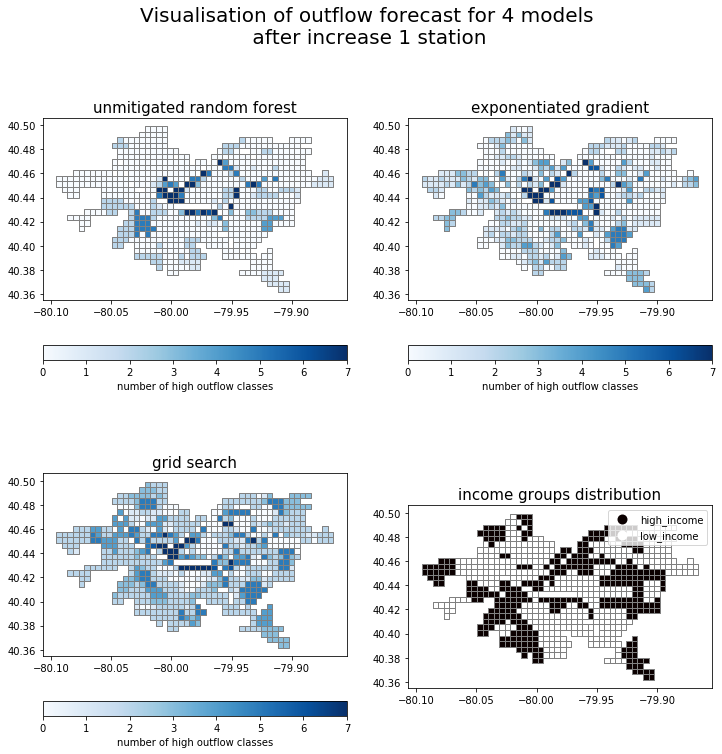

In [46]:
# grid search
fig, axes = plt.subplots(2,2, figsize = (12, 12))

ax1=axes[0,0]
ax2=axes[0,1]
ax3=axes[1,0]
ax4=axes[1,1]

pred_df_yearly.plot(column="new_pred_random_forest", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
                    legend = True, legend_kwds={'label': "number of high outflow classes",'orientation': "horizontal"}, ax = ax1, vmax = 7)
ax1.set_title("unmitigated random forest", fontsize=15)

pred_df_yearly.plot(column="new_pred_exp_grad", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
                    legend = True, legend_kwds={'label': "number of high outflow classes",'orientation': "horizontal"}, ax = ax2, vmax = 7)
ax2.set_title("exponentiated gradient", fontsize=15)

pred_df_yearly.plot(column="new_pred_grid_search", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
                    legend = True, legend_kwds={'label': "number of high outflow classes",'orientation': "horizontal"}, ax = ax3, vmax = 7)
ax3.set_title("grid search", fontsize=15)

pred_df_yearly.plot(column="income_group", cmap='hot', edgecolor = "grey", figsize=(2, 2),  
                    legend = True, categorical = True, ax = ax4)
ax4.set_title("income groups distribution", fontsize=15)

fig.suptitle(('Visualisation of outflow forecast for 4 models\n after increase {} station').format(NUM_STATIONS_INC), fontsize=20)

FIG_NAME = ("fig_after_inc_{}_station").format(NUM_STATIONS_INC)
# plt.savefig(os.path.join(save_dir_forecast, CITY + FIG_NAME))

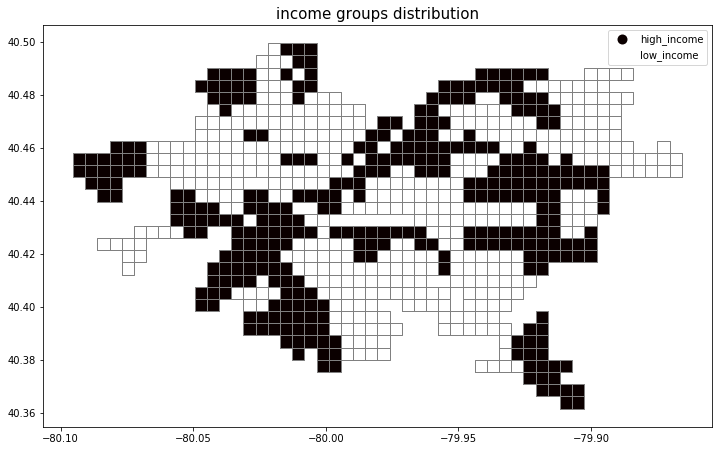

In [47]:
fig, axes = plt.subplots(figsize = (12, 12))
pred_df_yearly.plot(column="income_group", cmap='hot', edgecolor = "grey", figsize=(2, 2),  
                    legend = True, categorical = True, ax = axes)
axes.set_title("income groups distribution", fontsize=15)
FIG_NAME = "income_group_distribution"
plt.savefig(os.path.join(save_dir_forecast, CITY + FIG_NAME))

## Analysis

In [48]:
def forecast_res_calc(pred_df_yearly_geo):
    
    high_inc = pred_df_yearly_geo[pred_df_yearly_geo["income_group"] == "high_income"]
    low_inc = pred_df_yearly_geo[pred_df_yearly_geo["income_group"] == "low_income"]

    random_forest_diff =  ((low_inc.new_pred_random_forest.sum())/len(low_inc)) / ((high_inc.new_pred_random_forest.sum())/len(high_inc))
    exp_grad_diff =  ((low_inc.new_pred_exp_grad.sum())/len(low_inc)) / ((high_inc.new_pred_exp_grad.sum())/len(high_inc))
    grid_search_diff =  ((low_inc.new_pred_grid_search.sum())/len(low_inc)) / ((high_inc.new_pred_grid_search.sum())/len(high_inc))

    return random_forest_diff, exp_grad_diff, grid_search_diff

In [49]:
FILE_NAME = "forc_res_summary_SP.csv"

PATH1 = os.path.join(save_dir_forecast, CITY + FILE_NAME)

if path.exists(PATH1):
    forc_res_summary = pd.read_csv(PATH1, index_col = 0)
else:
    forc_res_summary = pd.DataFrame(0, columns = ["random_forest_ratio", "exp_grad_ratio", "grid_search_ratio"], index = ["inc_{}_station".format(NUM_STATIONS_INC)])

In [50]:
forc_res_summary.loc["inc_{}_station".format(NUM_STATIONS_INC), "random_forest_ratio"] = forecast_res_calc(pred_df_yearly)[0]
forc_res_summary.loc["inc_{}_station".format(NUM_STATIONS_INC), "exp_grad_ratio"] = forecast_res_calc(pred_df_yearly)[1]
forc_res_summary.loc["inc_{}_station".format(NUM_STATIONS_INC), "grid_search_ratio"] = forecast_res_calc(pred_df_yearly)[2]

In [51]:
forc_res_summary.to_csv(os.path.join(save_dir_forecast, CITY + FILE_NAME))